<h1><center>CMSC320 Final Project:</h1></center>
<h1><center>A Data Science Analysis of Counter Strike: Global Offensive's Most Clutch Player</center></h1>
<h2><center>Ashwath Krishnan and Tejas Latupalli</center></h2>

## Introduction

Over the past few years, competitive video games, otherwise known as esports, have become increasingly popular. What began as a cult phenomenon of nerds playing games at their local internet cafe's for a chance to win free food or a couple of bucks in the early 2000s has blossomed into a worldwide sensation that is honestly hard to comprehend. These days, multiple games have reached the level of being able to hold events in large traditional sports arenas like Madison Square Garden and the Oracle Arena. Prize purses for these events routinely break millions of dollars, and the players at the top of these games are treated like celebrities. 

One of the most popular esports titles throughout the 2010s has been Counter Strike: Global Offensive, commonly abbreviated CS:GO, a team-based tactical first-person shooter game played on PC. The game released in 2013, however earlier versions of the game have existed long before that, dating back to as early as 1999. CS:GO has, over its seven year tenure as an esports title, had hundreds of top level tournaments and hundreds of players and teams striving to call themselves the best. In this tutorial, we will go through the full data science pipeline as it relates to CS:GO's professional scene, attempt to answer a couple of questions through exploratory data analysis, and create a machine learning model by which future predictions about players and teams can be made.

More information about CS:GO as a game can be found [here](https://en.wikipedia.org/wiki/Counter-Strike:_Global_Offensive).

## Environment

The following tutorial will use Python version 3.7.7 and require the following imports:

In [57]:
import pandas as pd
import numpy as np
import datetime
import requests
import re
import math
import os
import _pickle as pickle
from datetime import date, timedelta
from bs4 import BeautifulSoup
from plotnine import *

## Data Collection

The primary stats repository for CS:GO is [HLTV](https://hltv.org). They, as a company, have collected data on professional games dating back to the earlier versions of Counter Strike. And ever since late 2015, they have kept a team ranking based on performance over the previous few months. These rankings are the most universally accepted ranking system in the CS:GO community, and are (for the most part) treated as accurate. In addition to these rankings, HLTV has come up with a rating system to simplify all of the factors of a player's performance in a match to just a single number. This rating, commonly known as a player's HLTV rating, accounts for a myriad of factors in the game, including but not limited to, the number of eliminations a player gets in the match, the amount of times the player gets eliminated, the player's clutch plays (1vX scenarios), and how much damage the player is doing to the enemy team as a whole.

One factor that the HLTV rating does not take into account, however, is the skill level of the opposing team. Because of this, there are many players at the top level of the game who seemingly have high ratings, but upon further inspection of their match history, show a history of padding their stats against teams of a significantly lower calibre. I mention this because, looking ahead to the exploratory data analysis section of this tutorial, we will be attempting to answer the question "who is CS:GO's most clutch player", defining clutch as performing when it matters, against the better teams in the world. Keep this in mind as we start to scrape data, as it will be very useful when trying to understand why we are scraping certain things.

First, since we are attempting to see which players perform against the best teams in the world, it makes sense to start by scraping historical ranking data, just so that when we get to scraping match data, we will have an established dataset of what each team was ranked at the time. One mild annoyance of this is that HLTV rankings are published weekly, on mondays, on a separate webpage every time, so we'll need to get crafty with the way we grab this data. First we're going to write a utility function that grabs every monday between the start of HLTV's rankings and 2020. 

You'll notice we've upper bounded the dates in this function to the end of 2019, just because the Covid-19 pandemic made the top level of CS:GO very erratic and unstable throughout 2020.

In [30]:
def all_mondays(year):  # Utility method to fetch all mondays in a given year
    return pd.date_range(start=str(year), end=str(year + 1), freq='W-MON').tolist()

def all_ranking_days():
    days = []
    firstRanking = pd.to_datetime(pd.Timestamp(year=2015, month=10, day=26))
    for i in range(2015, 2020):
        days += all_mondays(i)

    truedays = []
    for day in days:
        d = day.to_pydatetime()
        print(d)
        if d >= firstRanking:
            truedays.append(d)

    return truedays

Next, we have to pay attention to how the URL for each ranking page for each date is formatted, so that we can manipulate the URLs and grab data accordingly. Upon inspection, the way HLTV catelogs the team ranking is following format: hltv.org/ranking/teams/`<YEAR>`/`<MONTH>`/`<DAY>`.

Based on this, we can use our previously defined utility method to generate a list of days we have to get the rankings for, then iterate through those days and insert the date in the above format, use a bit of webscraping magic with BeautifulSoup, and we should be able to get the historical ranking data with minimal issues.

In [31]:
months = {
    1: "january",
    2: "february",
    3: "march",
    4: "april",
    5: "may",
    6: "june",
    7: "july",
    8: "august",
    9: "september",
    10: "october",
    11: "november",
    12: "december"
}

def scrape_rankings():
    days = all_ranking_days() # call utility function to get the ranking days in our range
    rows = []
    for i in range(0, len(days)): # iterate through the days
        day = days[i]
        next_day = days[i + 1] - \
            datetime.timedelta(days=1) if i < len(days) - 1 else date.today()
        # construction of URL
        url = "https://www.hltv.org/ranking/teams/" + \
            str(day.year) + "/" + \
            months[day.month] + "/" + str(day.day)
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        team_list = soup.findAll("div", class_="ranked-team standard-box")
        pattern = re.compile("\#(\d+)")
        res = []
        for team in team_list: # iterate through teams in the week's ranking and get desired fields
            rank = pattern.match(
                team.find("span", class_="position").text).groups(1)[0]
            name = team.find("span", class_="name").text
            players = team.findAll("div", class_="nick")
            playernames = [player.text for player in players]
            date_range = pd.date_range(start=day, end=next_day)
            for d in date_range:
                res.append([d, name, rank, playernames]) # add 1 entry to the final data for every day in that week

        rows += res

    df = pd.DataFrame(data=rows, columns=["date", "name", "rank", "players"])
    return df

One quirk I should mention about the above method is that instead of just saving the ranking for the specific day we scraped it from, we saved the same ranking for every day in that week. This will make things much easier later on, and I just thought I should mention it.

Next, we're gonna make sure the results of this get cached, so that we don't have to run this expensive operation every time we want to test our code or make a change. This doesn't compromise the integrity of our data at all, either, because the stats and rankings from the past are never going to change.

In [32]:
ranking_pickle_filepath = "./data/data.pickle"

if not os.path.exists(ranking_pickle_filepath):
    rankings_df = scrape_rankings()
    rankings_df.to_pickle(ranking_pickle_filepath)
else:
    rankings_df = pd.read_pickle(ranking_pickle_filepath)

rankings_df

,date,name,rank,players
0,2015-10-26,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
1,2015-10-27,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
2,2015-10-28,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
3,2015-10-29,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
4,2015-10-30,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
...,...,...,...,...
46068,2020-05-09,HAVU,30,"[sAw, ZOREE, sLowi, doto, hoody]"
46069,2020-05-10,HAVU,30,"[sAw, ZOREE, sLowi, doto, hoody]"
46070,2020-05-11,HAVU,30,"[sAw, ZOREE, sLowi, doto, hoody]"
46071,2020-05-12,HAVU,30,"[sAw, ZOREE, sLowi, doto, hoody]"


As you can see, it worked! We now have historical ranking data stored in a dataframe. Next, we need information on match data. And since we're focusing on individual player performance, we're going to get our data from the [players section of HLTV](https://www.hltv.org/stats/players). The first step is to set our parameters, since HLTV has data from almost every professional CS:GO match ever played, including obscure semi-professional games. To try and eliminate outliers clouding up our data, we're going to set the match filter to LAN (since results achieved on a LAN setup hold much more weight in the eyes of the community than online games), and set the ranking filter to top 30 teams, as realistically we are looking for a player who has played at the highest level of the game. With these filters factored in, the URL we're going to be using to get the list of players is <https://www.hltv.org/stats/players?matchType=Lan&rankingFilter=Top30>. This link, however, doesn't give us the data we need. For that, we need to scrape individual player stats page URLs from this page, and grab our data from those individual pages (an example page for this would be <https://www.hltv.org/stats/players/7998/s1mple?matchType=Lan&rankingFilter=Top30>). So let's start by defining a method that will scrape the players page and grab the links we need.

In [33]:
players_link = "https://www.hltv.org/stats/players?startDate=all&matchType=Lan&rankingFilter=Top30"

def scrape_player_links():
    page = requests.get(players_link)
    soup = BeautifulSoup(page.content, "html.parser")
    players_table = soup.find(
        "table", class_="stats-table player-ratings-table")
    table_body = players_table.find("tbody")
    player_cells = table_body.findAll("tr")
    player_links = {}
    for player_cell in player_cells:
        player_col = player_cell.find("td", class_="playerCol")
        player_link_tag = player_col.find("a")
        player_link = player_link_tag["href"]
        player_name = player_link_tag.text
        player_links[player_name] = "https://www.hltv.org" + player_link

    return player_links

With that done, we can now look at the format of the individual players' stats page, and get to work on scraping that in a similar fashion to how we got the rankings data. This page is slightly more complex in terms of its formatting, so we'll need to be a bit careful and use some regular expression magic to grab the actual values we need from the table. Let's define a function to do this.

In [34]:
def scrape_player_data(links):
    data = []
    score_pattern = re.compile("\((\d+)\)") # regex pattern that will help a lot with the fields on this page
    kd_pattern = re.compile("(\d+) - (\d+)") # another regex pattern that will help a lot
    for player, link in links.items(): # iterate through each link
        matches_link = link.replace("/players", "/players/matches") # get to the matches page from the player's overview page
        page = requests.get(matches_link)
        soup = BeautifulSoup(page.content, "html.parser")
        stats_table = soup.find("table")
        table_body = stats_table.find("tbody")
        match_rows = table_body.findAll("tr")
        for match_row in match_rows: # go through all the matches the player has on record and pull out the desired fields
            cells = match_row.findAll("td")
            date = cells[0].find("div", class_="time").text.strip()
            team = cells[1].findAll("span")[0].text.strip()
            rounds_text = cells[1].findAll("span")[1].text.strip()
            team_rounds = score_pattern.match(rounds_text).group(1)
            opposing_team = cells[2].findAll("span")[0].text.strip()
            opposing_team_rounds = score_pattern.match(
                cells[2].findAll("span")[1].text.strip()).group(1)
            map_played = cells[3].text.strip()
            kills = kd_pattern.match(cells[4].text.strip()).group(1)
            deaths = kd_pattern.match(cells[4].text.strip()).group(2)
            differential = cells[5].text.strip()
            rating = cells[6].text.strip()
            data.append([player, date, team, team_rounds, opposing_team,
                         opposing_team_rounds, map_played, kills, deaths, differential, rating])

    columns = ["player", "date", "team", "team_rounds", "opposing_team",
               "opposing_team_rounds", "map", "kills", "deaths", "differential", "rating"]
    df = pd.DataFrame(data=data, columns=columns)

    return df

And similar to the rankings data, we're going to cache this data once we have it to save us time and save the wonderful people over at HLTV the cost of serving us these same webpages over and over. 

In [35]:
match_pickle_filepath = "./data/matches.pickle"

if not os.path.exists(match_pickle_filepath):
    player_links = scrape_player_links()
    player_data = scrape_player_data(player_links)
    player_data.to_pickle(match_pickle_filepath)
else:
    player_data = pd.read_pickle(match_pickle_filepath)

player_data

,player,date,team,team_rounds,opposing_team,opposing_team_rounds,map,kills,deaths,differential,rating
0,s1mple,1/3/20,Natus Vincere,16,G2,2,mrg,14,2,+12,1.57
1,s1mple,1/3/20,Natus Vincere,16,G2,13,d2,26,19,+7,1.35
2,s1mple,1/3/20,Natus Vincere,16,G2,4,nuke,19,8,+11,1.73
3,s1mple,29/2/20,Natus Vincere,16,Astralis,5,nuke,18,11,+7,1.52
4,s1mple,29/2/20,Natus Vincere,16,Astralis,5,d2,25,11,+14,2.09
...,...,...,...,...,...,...,...,...,...,...,...
34268,daps,8/11/15,Conquest,16,Dignitas,9,cbl,18,16,+2,1.13 *
34269,daps,7/11/15,Conquest,22,Liquid,18,cbl,14,32,-18,0.47 *
34270,daps,7/11/15,Conquest,16,Liquid,11,trn,18,18,0,0.94 *
34271,daps,7/11/15,Conquest,19,Virtus.pro,22,inf,20,34,-14,0.65 *


And with that, the data collection stage of this tutorial is complete! Next, we need to make some modifications to the data for our use.

## Tidying and Manipulating Our Data

In this step we're going to be making some changes to the format of our data to make it easier for us in the long run and to generate some statistics that HLTV didn't natively provide on the stats page. Let's start with the rankings dataframe, as there is only a single change that needs to be made there. Let's change the format of the date column to be a true Python datetime formatted column, to make working with those dates easier later. After this, since we're done with that dataframe, lets cache it again as a "tidy" version.

In [36]:
tidied_rankings_path = "./data/tidied/rankings.pickle"

if not os.path.exists(tidied_rankings_path):
    rankings_df["date"] = pd.to_datetime(rankings_df["date"], format="%Y-%m-%d")
    rankings_df.to_pickle(tidied_rankings_path)
else:
    rankings_df = pd.read_pickle(tidied_rankings_path)

rankings_df

,date,name,rank,players
0,2015-10-26,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
1,2015-10-27,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
2,2015-10-28,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
3,2015-10-29,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
4,2015-10-30,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
...,...,...,...,...
46068,2020-05-09,HAVU,30,"[sAw, ZOREE, sLowi, doto, hoody]"
46069,2020-05-10,HAVU,30,"[sAw, ZOREE, sLowi, doto, hoody]"
46070,2020-05-11,HAVU,30,"[sAw, ZOREE, sLowi, doto, hoody]"
46071,2020-05-12,HAVU,30,"[sAw, ZOREE, sLowi, doto, hoody]"


Before we move on to the player_data dataframe, lets think for a second the main task we're trying to accomplish. Since we're trying to add context about the opposing team's level to each match, we need a way to get the ranking for a specific team during the time of a specific match. Lucky for us, every match we've logged into our dataframe has a "date" parameter, and we separated the weekly rankings into individual days earlier so all we have to do is write a utility function to accomplish this. We'll set the value of unranked teams to be -1, for now.

In [37]:
def get_opponent_rank(opponent, date):
    subset = rankings_df[rankings_df["date"] == date] # get rankings at that date
    if len(subset) == 0:
        return -1
    rows = subset[subset["name"] == opponent]
    if(len(rows) == 0):
        return -1
    row = rows.iloc[[0]]
    if len(row) == 0:
        return -1
    return row["rank"].iloc[0]

Next, we can make all the changes we want to our dataset. Let's start by converting the date column as we did to the rankings dataframe. In the same vein, lets set all the numerical fields to a true numeric format as well.

In addition to just column formatting, we're also going to add the following fields:

* KDR: The kill/death ratio of the player in the specific match, defined as (kills / deaths)
* KPR: The kills per round statistic of the player in the specific match, defined as  (kills / (team rounds + opposing team rounds))
* Win: A logical column defining if the match is a win or loss for the player in question by comparing the rounds his/her team won to the rounds the opposing team won
* Opposing Team Rank: Using the previously defined utility function, we're going to iterate through our dataset and add the ranks of the opponent as a numerical column
* Team Rank: The player's team's rank using the same method defined above
* Rank Differential: The difference in rank between the the two teams (note that if either team is unranked, we're going to treat the differential as infinite)

And finally, we're going to remove all of the matches outside of the range where HLTV has been keeping rankings, just so that we remain consistent. At the end of all of this, we're going to re-cache our dataset, so that we don't have to do this expensive process again between runs.

In [43]:
tidied_player_data_path = "./data/tidied/matches.pickle"

if not os.path.exists(tidied_player_data_path):
    # correct data formats

    player_data["date"] = pd.to_datetime(
        player_data["date"], format="%d/%m/%y")
    player_data["team_rounds"] = pd.to_numeric(player_data["team_rounds"])
    player_data["opposing_team_rounds"] = pd.to_numeric(
        player_data["opposing_team_rounds"])
    player_data["kills"] = pd.to_numeric(player_data["kills"])
    player_data["deaths"] = pd.to_numeric(player_data["deaths"])
    player_data["differential"] = pd.to_numeric(player_data["differential"])
    player_data["rating"] = player_data["rating"].replace(to_replace="\*", value="", regex=True)
    player_data["rating"] = player_data["rating"].str.strip()

    # adding necessary fields
    player_data["win"] = player_data["team_rounds"] > player_data["opposing_team_rounds"]
    player_data["kdr"] = player_data["kills"] / player_data["deaths"]
    player_data["kpr"] = player_data["kills"] / \
        (player_data["team_rounds"] + player_data["opposing_team_rounds"])

    player_data["opposing_team_rank"] = -1  # just to create the column
    player_data["team_rank"] = -1
    for index, row in player_data.iterrows():
        player_data.at[index, "opposing_team_rank"] = get_opponent_rank(
            row["opposing_team"], row["date"])
        player_data.at[index, "team_rank"] = get_opponent_rank(
            row["team"], row["date"])

    player_data["opposing_team_rank"] = pd.to_numeric(player_data["opposing_team_rank"])
    player_data["team_rank"] = pd.to_numeric(player_data["team_rank"])
    
    player_data["rank_differential"] = player_data.apply(lambda row: float(
        "inf") if row["team_rank"] == -1 or row["opposing_team_rank"] == -1 else row["opposing_team_rank"] - row["team_rank"], axis=1)

    # filtering matches to fit desired timeframe
    start = pd.to_datetime('2015-10-26')
    end = pd.to_datetime('2019-12-30')
    player_data = player_data.query(
        'date > @start and date < @end').reset_index(drop=True)

    player_data.to_pickle(tidied_player_data_path)

else:
    player_data = pd.read_pickle(tidied_player_data_path)

player_data

,player,date,team,team_rounds,opposing_team,opposing_team_rounds,map,kills,deaths,differential,rating,win,kdr,kpr,opposing_team_rank,team_rank,rank_differential,importance
0,s1mple,2019-12-21,Natus Vincere,14,Evil Geniuses,16,d2,22,20,2,1.07,False,1.100000,0.733333,5,10,-5.0,2.0
1,s1mple,2019-12-21,Natus Vincere,10,Evil Geniuses,16,mrg,16,18,-2,0.94,False,0.888889,0.615385,5,10,-5.0,2.0
2,s1mple,2019-12-19,Natus Vincere,16,Heroic,9,inf,21,13,8,1.42,True,1.615385,0.840000,21,10,11.0,1.0
3,s1mple,2019-12-19,Natus Vincere,16,Heroic,6,trn,24,10,14,1.80,True,2.400000,1.090909,21,10,11.0,1.0
4,s1mple,2019-12-19,Natus Vincere,9,Heroic,16,nuke,20,16,4,1.11,False,1.250000,0.800000,21,10,11.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32666,daps,2015-11-08,Conquest,16,Dignitas,9,cbl,18,16,2,1.13,True,1.125000,0.720000,-1,-1,inf,1.0
32667,daps,2015-11-07,Conquest,22,Liquid,18,cbl,14,32,-18,0.47,True,0.437500,0.350000,-1,-1,inf,1.0
32668,daps,2015-11-07,Conquest,16,Liquid,11,trn,18,18,0,0.94,True,1.000000,0.666667,-1,-1,inf,1.0
32669,daps,2015-11-07,Conquest,19,Virtus.pro,22,inf,20,34,-14,0.65,False,0.588235,0.487805,-1,-1,inf,1.0


Much better. 

I think it's time we start thinking about the specific parameters of the question we're trying to solve. We are, in essence, trying to find out which CS:GO players play best at against all levels, not just players who pad their stats against weaker opposition. To do this, we're going to develop an "importance" metric for each match, based on the rank differential between the two teams. We will define this "importance" based on the following piecewise forumula:

<center>y = 2 for x < 1</center>
<center>$y = \frac{3}{x + 1} + 0.5$ for 1 <= x <= 5</center>
<center>y = 1 for x >= 5</center>
<center>Where y is the importance of a particular game and x is the rank differential between the teams</center>
    
To explain this a bit, if a team plays against a team higher ranked than them, the game will have an importance rating of 2 for the player in question. If a team plays against a team which is lower ranked than them, but is within the range of 1 < x <= 5, some importance will still be given to the game, but on a diminishing scale, as as the higher the differential is, the more we expect the higher ranked team to come out victorius. After the differential crosses 5, the game recieves an importance of 1, as the player in question's team is fully expected to win the match. 
    
Let's use this formula to add a column to our dataframe.

In [62]:
def importance(row):
    if row["rank_differential"] <= 2:
        return 1.5
    elif row["rank_differential"] <= 5:
        return (3 / (row["rank_differential"] + 1) + 0.5)
    else:
        return 1

if importance not in player_data:
    player_data["importance"] = player_data.apply(importance, axis=1)
    player_data.to_pickle(tidied_player_data_path)
    
player_data.head()

,player,date,team,team_rounds,opposing_team,opposing_team_rounds,map,kills,deaths,differential,rating,win,kdr,kpr,opposing_team_rank,team_rank,rank_differential,importance,performance
0,s1mple,2019-12-21,Natus Vincere,14,Evil Geniuses,16,d2,22,20,2,1.07,False,1.100000,0.733333,5,10,-5.0,1.5,2.14
1,s1mple,2019-12-21,Natus Vincere,10,Evil Geniuses,16,mrg,16,18,-2,0.94,False,0.888889,0.615385,5,10,-5.0,1.5,1.88
2,s1mple,2019-12-19,Natus Vincere,16,Heroic,9,inf,21,13,8,1.42,True,1.615385,0.840000,21,10,11.0,1.0,1.42
3,s1mple,2019-12-19,Natus Vincere,16,Heroic,6,trn,24,10,14,1.80,True,2.400000,1.090909,21,10,11.0,1.0,1.80
4,s1mple,2019-12-19,Natus Vincere,9,Heroic,16,nuke,20,16,4,1.11,False,1.250000,0.800000,21,10,11.0,1.0,1.11


Finally, lets create a column called performance, which is the result of multiplying a given match's importance statistic with the player in question's rating during that match. 

In [63]:
player_data["rating"] = pd.to_numeric(player_data["rating"])
player_data["performance"] = player_data["importance"] * player_data["rating"]

player_data

,player,date,team,team_rounds,opposing_team,opposing_team_rounds,map,kills,deaths,differential,rating,win,kdr,kpr,opposing_team_rank,team_rank,rank_differential,importance,performance
0,s1mple,2019-12-21,Natus Vincere,14,Evil Geniuses,16,d2,22,20,2,1.07,False,1.100000,0.733333,5,10,-5.0,1.5,1.605
1,s1mple,2019-12-21,Natus Vincere,10,Evil Geniuses,16,mrg,16,18,-2,0.94,False,0.888889,0.615385,5,10,-5.0,1.5,1.410
2,s1mple,2019-12-19,Natus Vincere,16,Heroic,9,inf,21,13,8,1.42,True,1.615385,0.840000,21,10,11.0,1.0,1.420
3,s1mple,2019-12-19,Natus Vincere,16,Heroic,6,trn,24,10,14,1.80,True,2.400000,1.090909,21,10,11.0,1.0,1.800
4,s1mple,2019-12-19,Natus Vincere,9,Heroic,16,nuke,20,16,4,1.11,False,1.250000,0.800000,21,10,11.0,1.0,1.110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32666,daps,2015-11-08,Conquest,16,Dignitas,9,cbl,18,16,2,1.13,True,1.125000,0.720000,-1,-1,inf,1.0,1.130
32667,daps,2015-11-07,Conquest,22,Liquid,18,cbl,14,32,-18,0.47,True,0.437500,0.350000,-1,-1,inf,1.0,0.470
32668,daps,2015-11-07,Conquest,16,Liquid,11,trn,18,18,0,0.94,True,1.000000,0.666667,-1,-1,inf,1.0,0.940
32669,daps,2015-11-07,Conquest,19,Virtus.pro,22,inf,20,34,-14,0.65,False,0.588235,0.487805,-1,-1,inf,1.0,0.650


In [74]:
player_data["performance_residual"] = player_data["performance"] - player_data["rating"]
player_data

,player,date,team,team_rounds,opposing_team,opposing_team_rounds,map,kills,deaths,differential,rating,win,kdr,kpr,opposing_team_rank,team_rank,rank_differential,importance,performance,performance_residual
0,s1mple,2019-12-21,Natus Vincere,14,Evil Geniuses,16,d2,22,20,2,1.07,False,1.100000,0.733333,5,10,-5.0,1.5,1.605,0.535
1,s1mple,2019-12-21,Natus Vincere,10,Evil Geniuses,16,mrg,16,18,-2,0.94,False,0.888889,0.615385,5,10,-5.0,1.5,1.410,0.470
2,s1mple,2019-12-19,Natus Vincere,16,Heroic,9,inf,21,13,8,1.42,True,1.615385,0.840000,21,10,11.0,1.0,1.420,0.000
3,s1mple,2019-12-19,Natus Vincere,16,Heroic,6,trn,24,10,14,1.80,True,2.400000,1.090909,21,10,11.0,1.0,1.800,0.000
4,s1mple,2019-12-19,Natus Vincere,9,Heroic,16,nuke,20,16,4,1.11,False,1.250000,0.800000,21,10,11.0,1.0,1.110,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32666,daps,2015-11-08,Conquest,16,Dignitas,9,cbl,18,16,2,1.13,True,1.125000,0.720000,-1,-1,inf,1.0,1.130,0.000
32667,daps,2015-11-07,Conquest,22,Liquid,18,cbl,14,32,-18,0.47,True,0.437500,0.350000,-1,-1,inf,1.0,0.470,0.000
32668,daps,2015-11-07,Conquest,16,Liquid,11,trn,18,18,0,0.94,True,1.000000,0.666667,-1,-1,inf,1.0,0.940,0.000
32669,daps,2015-11-07,Conquest,19,Virtus.pro,22,inf,20,34,-14,0.65,False,0.588235,0.487805,-1,-1,inf,1.0,0.650,0.000


And with that, we have successfully prepared our data for the analysis we will be doing in the rest of this tutorial!

## Exploratory Data Analysis

Let's start this section by creating a dataframe of the summarized results of our data.

In [76]:
averages = player_data.groupby(["player"]).mean()

averages.sort_values(by=["performance_residual"], ascending=False).head(20)

,team_rounds,opposing_team_rounds,kills,deaths,differential,rating,win,kdr,kpr,opposing_team_rank,team_rank,rank_differential,importance,performance,performance_residual
player,,,,,,,,,,,,,,,
jks,12.711048,13.713881,18.110482,17.246459,0.864023,1.068074,0.453258,1.125401,0.680996,11.436261,15.580737,inf,1.334419,1.411895,0.343822
AZR,12.711048,13.713881,17.396601,18.600567,-1.203966,0.994164,0.453258,0.969954,0.653455,11.436261,15.580737,inf,1.334419,1.323514,0.329350
jkaem,12.763804,13.641104,18.226994,18.567485,-0.340491,1.061840,0.453988,1.033587,0.686214,10.447853,11.886503,inf,1.315644,1.382448,0.320607
kennyS,13.852525,13.048485,19.943434,16.903030,3.040404,1.149535,0.545455,1.301597,0.744685,9.577778,10.185859,inf,1.274444,1.457278,0.307742
LUCAS1,13.205387,13.296296,17.185185,17.986532,-0.801347,1.039865,0.508418,1.024633,0.650622,10.582492,12.148148,inf,1.295960,1.338473,0.298608
Snappi,12.955017,13.460208,16.280277,18.252595,-1.972318,0.961834,0.467128,0.945710,0.617201,11.058824,15.598616,inf,1.316955,1.258450,0.296616
NiKo,13.856589,12.482558,21.031008,17.368217,3.662791,1.235233,0.562016,1.317454,0.800237,7.990310,5.333333,inf,1.238275,1.529391,0.294158
aizy,13.394068,13.493644,18.129237,17.970339,0.158898,1.069237,0.504237,1.103108,0.675815,9.091102,10.675847,inf,1.278284,1.359410,0.290173
REZ,13.236620,13.352113,18.428169,18.129577,0.298592,1.083437,0.476056,1.080798,0.692235,9.157746,10.614085,inf,1.274225,1.369561,0.286124


With that out of the way, we are free to start graphing some of our findings so that we can get a visual representation. The first thing we are going to graph is the performance rating for every match vs the player in question's rating for that match. This should give us a better idea of how often high ratings do not necessarily correspond to high impact.

C:\Users\Ashwath Krishnan\AppData\Local\Programs\Python\Python37\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


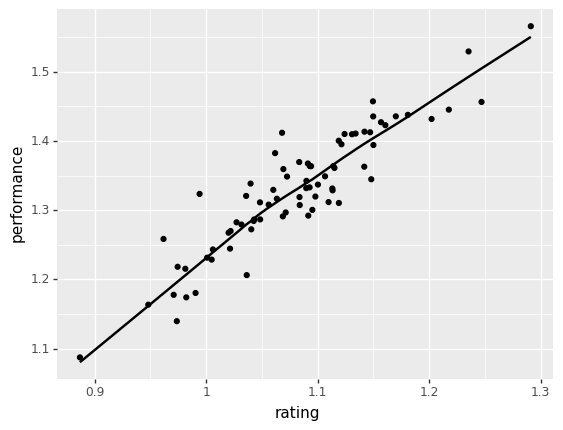

<ggplot: (-9223371876927079780)>

In [77]:
(ggplot(averages, aes(x='rating', y='performance'))
    + geom_point()
    + geom_smooth())

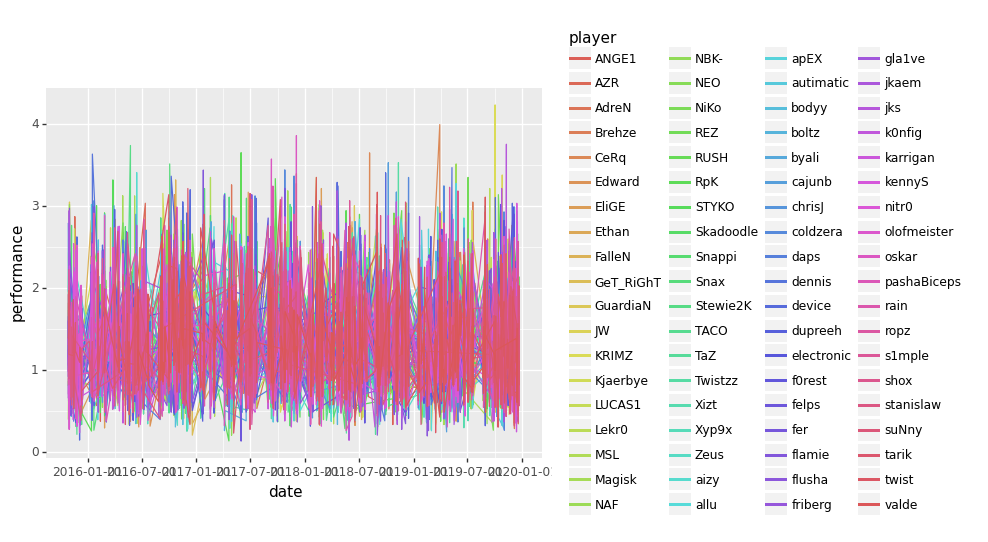

<ggplot: (-9223371876928022928)>

In [87]:
(ggplot(player_data, aes(x="date", y="performance"))
    + geom_line(aes(color="player")))